# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

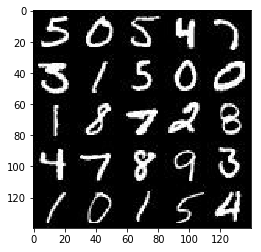

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

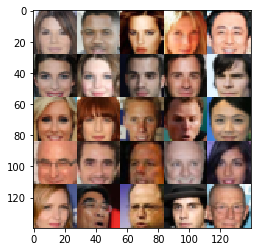

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function - DONE
    input_real = tf.placeholder(tf.float32, shape=(None,image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(),name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
#passing in 28*28*3 images to the discriminator
#returns output (Real or fake) and also, logits which are used to calculate cross entropy loss

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        ## 28x28x3
        layer_1 = tf.layers.conv2d(images, filters=64, kernel_size=4, strides=2, padding='same')
        layer_1 = tf.maximum(0.1 * layer_1, layer_1)
        # 14x14x64
        
        layer_2 = tf.layers.conv2d(layer_1, filters=128, kernel_size=4 , strides=2, padding='same')
        layer_2 = tf.layers.batch_normalization(layer_2, training=True)
        layer_2 = tf.maximum(0.1 * layer_2, layer_2)
        # 7x7x128
        
        layer_3 = tf.layers.conv2d(layer_2, filters=256, kernel_size=4, strides=2, padding='same')
        layer_3 = tf.layers.batch_normalization(layer_3, training=True)
        layer_3 = tf.maximum(0.1 * layer_3, layer_3)
        #4x4x256
        
        flattened = tf.reshape(layer_3, (-1, 4*4*256))
        #4096
        
        logits = tf.layers.dense(flattened, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse= not is_train):
        
        layer_1 = tf.layers.dense(z, 7*7*512)
        layer_1 = tf.reshape(layer_1, (-1, 7, 7, 512))
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        layer_1 = tf.maximum(0.1 * layer_1, layer_1)
        
        layer_2 = tf.layers.conv2d_transpose(layer_1, 256, 5, 2, 'same')
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        layer_2 = tf.maximum(0.1 * layer_2, layer_2)
        
        layer_3 = tf.layers.conv2d_transpose(layer_2, 128, 5, 2, 'same')
        layer_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        layer_3 = tf.maximum(0.1 * layer_3, layer_3)
       
        logits = tf.layers.conv2d_transpose(layer_3, out_channel_dim, 5, 1, 'same')        
        output = tf.tanh(logits)

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, True)
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_model_real)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real)*0.9))
    d_loss = d_loss_fake + d_loss_real
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]


    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)


    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_optimizer, g_optimizer = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_optimizer, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_optimizer, feed_dict={input_real: batch_images,input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{};".format(epoch_i + 1, epochs), "Discriminator Loss: {:.4f};".format(train_loss_d), "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2; Discriminator Loss: 0.3784; Generator Loss: 10.9893
Epoch 1/2; Discriminator Loss: 0.3450; Generator Loss: 8.9314
Epoch 1/2; Discriminator Loss: 0.3494; Generator Loss: 5.0729
Epoch 1/2; Discriminator Loss: 1.0433; Generator Loss: 2.6370
Epoch 1/2; Discriminator Loss: 0.7526; Generator Loss: 2.0394
Epoch 1/2; Discriminator Loss: 0.3983; Generator Loss: 3.9431
Epoch 1/2; Discriminator Loss: 0.3555; Generator Loss: 4.9935
Epoch 1/2; Discriminator Loss: 0.3538; Generator Loss: 4.6934
Epoch 1/2; Discriminator Loss: 0.3465; Generator Loss: 5.2253
Epoch 1/2; Discriminator Loss: 0.3430; Generator Loss: 6.0294


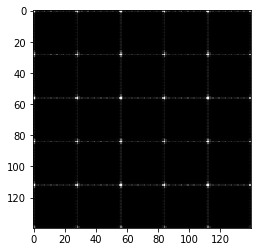

Epoch 1/2; Discriminator Loss: 0.3410; Generator Loss: 5.5489
Epoch 1/2; Discriminator Loss: 0.3378; Generator Loss: 6.3132
Epoch 1/2; Discriminator Loss: 0.3393; Generator Loss: 6.3153
Epoch 1/2; Discriminator Loss: 0.3368; Generator Loss: 5.9087
Epoch 1/2; Discriminator Loss: 0.3674; Generator Loss: 3.5641
Epoch 1/2; Discriminator Loss: 0.5587; Generator Loss: 1.7124
Epoch 1/2; Discriminator Loss: 1.0208; Generator Loss: 1.1270
Epoch 1/2; Discriminator Loss: 0.8157; Generator Loss: 1.4805
Epoch 1/2; Discriminator Loss: 0.8256; Generator Loss: 1.5925
Epoch 1/2; Discriminator Loss: 0.9652; Generator Loss: 1.1349


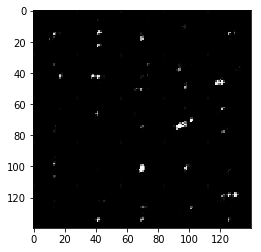

Epoch 1/2; Discriminator Loss: 1.0514; Generator Loss: 1.8164
Epoch 1/2; Discriminator Loss: 1.2042; Generator Loss: 0.7463
Epoch 1/2; Discriminator Loss: 2.1799; Generator Loss: 0.2088
Epoch 1/2; Discriminator Loss: 1.2589; Generator Loss: 0.7102
Epoch 1/2; Discriminator Loss: 1.0027; Generator Loss: 1.4926
Epoch 1/2; Discriminator Loss: 1.2793; Generator Loss: 0.6819
Epoch 1/2; Discriminator Loss: 1.4273; Generator Loss: 0.6071
Epoch 1/2; Discriminator Loss: 0.8920; Generator Loss: 1.6517
Epoch 1/2; Discriminator Loss: 1.3302; Generator Loss: 1.0555
Epoch 1/2; Discriminator Loss: 1.0850; Generator Loss: 1.1723


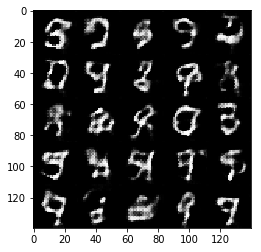

Epoch 1/2; Discriminator Loss: 1.2529; Generator Loss: 1.2195
Epoch 1/2; Discriminator Loss: 1.1520; Generator Loss: 0.8461
Epoch 1/2; Discriminator Loss: 1.1708; Generator Loss: 1.2687
Epoch 1/2; Discriminator Loss: 1.5397; Generator Loss: 0.4583
Epoch 1/2; Discriminator Loss: 1.1636; Generator Loss: 1.2623
Epoch 1/2; Discriminator Loss: 1.1203; Generator Loss: 0.9912
Epoch 1/2; Discriminator Loss: 1.2132; Generator Loss: 0.7154
Epoch 1/2; Discriminator Loss: 1.4806; Generator Loss: 0.4516
Epoch 1/2; Discriminator Loss: 1.1455; Generator Loss: 0.8309
Epoch 1/2; Discriminator Loss: 1.2517; Generator Loss: 0.6739


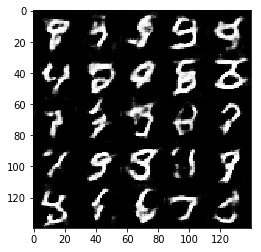

Epoch 1/2; Discriminator Loss: 1.1741; Generator Loss: 0.8783
Epoch 1/2; Discriminator Loss: 1.2272; Generator Loss: 1.3134
Epoch 1/2; Discriminator Loss: 1.1839; Generator Loss: 0.7146
Epoch 1/2; Discriminator Loss: 1.1994; Generator Loss: 0.6956
Epoch 1/2; Discriminator Loss: 1.0510; Generator Loss: 1.0181
Epoch 1/2; Discriminator Loss: 1.1905; Generator Loss: 0.8563
Epoch 1/2; Discriminator Loss: 1.2274; Generator Loss: 0.7380
Epoch 1/2; Discriminator Loss: 1.5075; Generator Loss: 0.4562
Epoch 1/2; Discriminator Loss: 1.1064; Generator Loss: 0.9204
Epoch 1/2; Discriminator Loss: 1.1956; Generator Loss: 0.7280


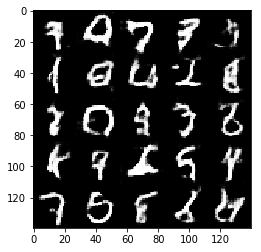

Epoch 1/2; Discriminator Loss: 1.3793; Generator Loss: 0.5036
Epoch 1/2; Discriminator Loss: 1.1598; Generator Loss: 0.9064
Epoch 1/2; Discriminator Loss: 1.3749; Generator Loss: 0.5309
Epoch 1/2; Discriminator Loss: 1.6680; Generator Loss: 0.3518
Epoch 1/2; Discriminator Loss: 1.0196; Generator Loss: 1.2086
Epoch 1/2; Discriminator Loss: 1.3181; Generator Loss: 1.8829
Epoch 1/2; Discriminator Loss: 1.4031; Generator Loss: 0.4830
Epoch 1/2; Discriminator Loss: 1.2227; Generator Loss: 0.6464
Epoch 1/2; Discriminator Loss: 1.0213; Generator Loss: 1.4038
Epoch 1/2; Discriminator Loss: 1.2655; Generator Loss: 2.1183


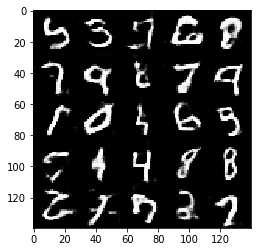

Epoch 2/2; Discriminator Loss: 1.2068; Generator Loss: 0.6954
Epoch 2/2; Discriminator Loss: 1.1283; Generator Loss: 1.7536
Epoch 2/2; Discriminator Loss: 1.1594; Generator Loss: 1.0041
Epoch 2/2; Discriminator Loss: 1.1764; Generator Loss: 0.9732
Epoch 2/2; Discriminator Loss: 1.0921; Generator Loss: 1.0097
Epoch 2/2; Discriminator Loss: 1.0227; Generator Loss: 0.8775
Epoch 2/2; Discriminator Loss: 1.0597; Generator Loss: 1.5954
Epoch 2/2; Discriminator Loss: 1.0749; Generator Loss: 0.9236
Epoch 2/2; Discriminator Loss: 1.1434; Generator Loss: 1.8512
Epoch 2/2; Discriminator Loss: 1.1240; Generator Loss: 1.0306


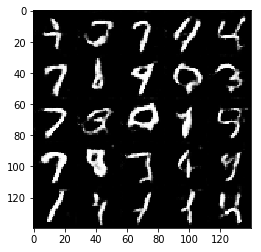

Epoch 2/2; Discriminator Loss: 0.9860; Generator Loss: 1.4335
Epoch 2/2; Discriminator Loss: 1.2581; Generator Loss: 0.6214
Epoch 2/2; Discriminator Loss: 1.1151; Generator Loss: 1.7551
Epoch 2/2; Discriminator Loss: 1.2314; Generator Loss: 0.6847
Epoch 2/2; Discriminator Loss: 1.0217; Generator Loss: 1.1541
Epoch 2/2; Discriminator Loss: 1.2007; Generator Loss: 0.6622
Epoch 2/2; Discriminator Loss: 1.2614; Generator Loss: 0.6618
Epoch 2/2; Discriminator Loss: 1.0254; Generator Loss: 1.1150
Epoch 2/2; Discriminator Loss: 1.1199; Generator Loss: 0.7580
Epoch 2/2; Discriminator Loss: 1.2602; Generator Loss: 0.6061


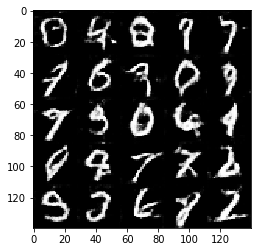

Epoch 2/2; Discriminator Loss: 1.0164; Generator Loss: 1.2602
Epoch 2/2; Discriminator Loss: 1.1482; Generator Loss: 0.9488
Epoch 2/2; Discriminator Loss: 0.9601; Generator Loss: 1.0281
Epoch 2/2; Discriminator Loss: 1.3889; Generator Loss: 0.5598
Epoch 2/2; Discriminator Loss: 1.0593; Generator Loss: 0.8679
Epoch 2/2; Discriminator Loss: 1.1065; Generator Loss: 0.9019
Epoch 2/2; Discriminator Loss: 0.9697; Generator Loss: 1.1435
Epoch 2/2; Discriminator Loss: 0.9528; Generator Loss: 1.2630
Epoch 2/2; Discriminator Loss: 1.1704; Generator Loss: 1.4868
Epoch 2/2; Discriminator Loss: 1.0076; Generator Loss: 1.0498


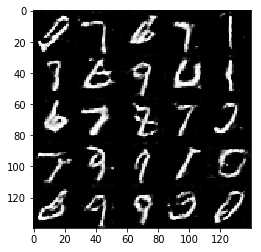

Epoch 2/2; Discriminator Loss: 1.0724; Generator Loss: 0.8253
Epoch 2/2; Discriminator Loss: 1.5795; Generator Loss: 0.3992
Epoch 2/2; Discriminator Loss: 1.0753; Generator Loss: 0.9476
Epoch 2/2; Discriminator Loss: 0.9785; Generator Loss: 1.4846
Epoch 2/2; Discriminator Loss: 1.0899; Generator Loss: 0.8201
Epoch 2/2; Discriminator Loss: 1.3574; Generator Loss: 0.5488
Epoch 2/2; Discriminator Loss: 1.1194; Generator Loss: 0.7675
Epoch 2/2; Discriminator Loss: 0.9407; Generator Loss: 1.0664
Epoch 2/2; Discriminator Loss: 0.8164; Generator Loss: 1.3176
Epoch 2/2; Discriminator Loss: 1.3545; Generator Loss: 0.5727


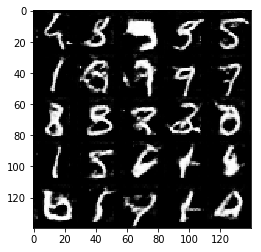

Epoch 2/2; Discriminator Loss: 1.1676; Generator Loss: 0.7247
Epoch 2/2; Discriminator Loss: 1.0186; Generator Loss: 0.8465
Epoch 2/2; Discriminator Loss: 1.2535; Generator Loss: 0.6651
Epoch 2/2; Discriminator Loss: 0.9107; Generator Loss: 1.4820
Epoch 2/2; Discriminator Loss: 1.6183; Generator Loss: 0.4506
Epoch 2/2; Discriminator Loss: 1.1246; Generator Loss: 1.2262
Epoch 2/2; Discriminator Loss: 1.2144; Generator Loss: 1.4856
Epoch 2/2; Discriminator Loss: 0.9443; Generator Loss: 1.8057
Epoch 2/2; Discriminator Loss: 1.0705; Generator Loss: 0.8161
Epoch 2/2; Discriminator Loss: 1.1870; Generator Loss: 2.4876


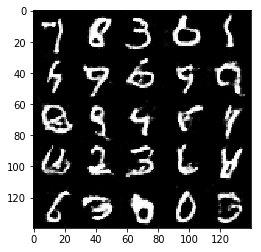

Epoch 2/2; Discriminator Loss: 1.0510; Generator Loss: 0.9286
Epoch 2/2; Discriminator Loss: 0.9793; Generator Loss: 1.1070
Epoch 2/2; Discriminator Loss: 0.8175; Generator Loss: 1.2993
Epoch 2/2; Discriminator Loss: 1.1095; Generator Loss: 0.8815
Epoch 2/2; Discriminator Loss: 1.0506; Generator Loss: 1.6661
Epoch 2/2; Discriminator Loss: 0.9698; Generator Loss: 1.0651
Epoch 2/2; Discriminator Loss: 1.3504; Generator Loss: 0.5949
Epoch 2/2; Discriminator Loss: 0.9805; Generator Loss: 0.9078
Epoch 2/2; Discriminator Loss: 1.1243; Generator Loss: 0.7525
Epoch 2/2; Discriminator Loss: 0.9744; Generator Loss: 0.9336


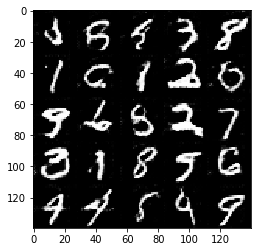

In [12]:
# batch_size  = 100
# z_dim = 100
# learning_rate = 0.001
# beta1 = 0.5
batch_size  = 100
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2; Discriminator Loss: 0.3914; Generator Loss: 4.1893
Epoch 1/2; Discriminator Loss: 0.4823; Generator Loss: 3.3016
Epoch 1/2; Discriminator Loss: 1.0287; Generator Loss: 0.9783
Epoch 1/2; Discriminator Loss: 0.4486; Generator Loss: 5.6629
Epoch 1/2; Discriminator Loss: 0.4011; Generator Loss: 3.3912
Epoch 1/2; Discriminator Loss: 0.4131; Generator Loss: 2.9374
Epoch 1/2; Discriminator Loss: 1.0544; Generator Loss: 2.8592
Epoch 1/2; Discriminator Loss: 0.8107; Generator Loss: 1.4038
Epoch 1/2; Discriminator Loss: 0.5147; Generator Loss: 4.2143
Epoch 1/2; Discriminator Loss: 0.4832; Generator Loss: 2.4054


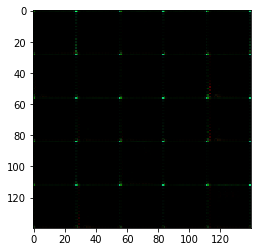

Epoch 1/2; Discriminator Loss: 0.4138; Generator Loss: 3.1885
Epoch 1/2; Discriminator Loss: 0.4950; Generator Loss: 2.4810
Epoch 1/2; Discriminator Loss: 0.6253; Generator Loss: 5.6697
Epoch 1/2; Discriminator Loss: 1.1626; Generator Loss: 0.8514
Epoch 1/2; Discriminator Loss: 1.2486; Generator Loss: 2.1842
Epoch 1/2; Discriminator Loss: 0.8865; Generator Loss: 1.5976
Epoch 1/2; Discriminator Loss: 1.3477; Generator Loss: 0.8525
Epoch 1/2; Discriminator Loss: 1.5663; Generator Loss: 0.7111
Epoch 1/2; Discriminator Loss: 0.8921; Generator Loss: 1.2906
Epoch 1/2; Discriminator Loss: 1.1625; Generator Loss: 1.1809


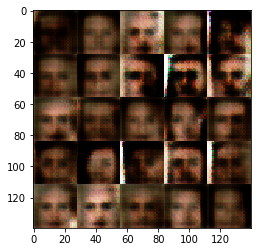

Epoch 1/2; Discriminator Loss: 1.1425; Generator Loss: 1.0085
Epoch 1/2; Discriminator Loss: 1.0449; Generator Loss: 1.1566
Epoch 1/2; Discriminator Loss: 1.0928; Generator Loss: 1.2792
Epoch 1/2; Discriminator Loss: 1.5246; Generator Loss: 0.4515
Epoch 1/2; Discriminator Loss: 1.4464; Generator Loss: 1.8014
Epoch 1/2; Discriminator Loss: 1.3515; Generator Loss: 1.7230
Epoch 1/2; Discriminator Loss: 1.3666; Generator Loss: 2.4954
Epoch 1/2; Discriminator Loss: 0.8146; Generator Loss: 1.3791
Epoch 1/2; Discriminator Loss: 0.5209; Generator Loss: 2.3644
Epoch 1/2; Discriminator Loss: 1.2210; Generator Loss: 1.3285


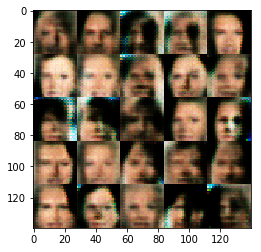

Epoch 1/2; Discriminator Loss: 1.0020; Generator Loss: 1.4454
Epoch 1/2; Discriminator Loss: 1.2192; Generator Loss: 0.7843
Epoch 1/2; Discriminator Loss: 0.9954; Generator Loss: 1.0718
Epoch 1/2; Discriminator Loss: 1.0265; Generator Loss: 1.1840
Epoch 1/2; Discriminator Loss: 1.9022; Generator Loss: 2.6604
Epoch 1/2; Discriminator Loss: 0.9233; Generator Loss: 0.9623
Epoch 1/2; Discriminator Loss: 1.3555; Generator Loss: 0.6188
Epoch 1/2; Discriminator Loss: 0.5830; Generator Loss: 1.7820
Epoch 1/2; Discriminator Loss: 1.1133; Generator Loss: 0.9581
Epoch 1/2; Discriminator Loss: 1.2674; Generator Loss: 1.4996


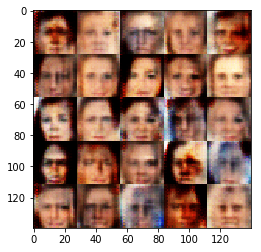

Epoch 1/2; Discriminator Loss: 1.2897; Generator Loss: 1.6483
Epoch 1/2; Discriminator Loss: 1.1417; Generator Loss: 0.9383
Epoch 1/2; Discriminator Loss: 1.0621; Generator Loss: 1.1581
Epoch 1/2; Discriminator Loss: 1.0784; Generator Loss: 0.8674
Epoch 1/2; Discriminator Loss: 1.3032; Generator Loss: 0.6746
Epoch 1/2; Discriminator Loss: 0.7267; Generator Loss: 1.6006
Epoch 1/2; Discriminator Loss: 1.2204; Generator Loss: 0.9364
Epoch 1/2; Discriminator Loss: 0.9169; Generator Loss: 1.1318
Epoch 1/2; Discriminator Loss: 0.9718; Generator Loss: 1.4884
Epoch 1/2; Discriminator Loss: 1.1516; Generator Loss: 0.7999


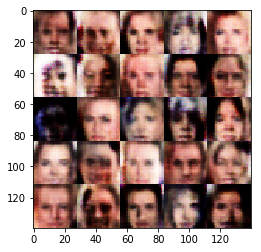

Epoch 1/2; Discriminator Loss: 1.5049; Generator Loss: 1.7983
Epoch 1/2; Discriminator Loss: 1.4678; Generator Loss: 0.4628
Epoch 1/2; Discriminator Loss: 1.2075; Generator Loss: 0.6235
Epoch 1/2; Discriminator Loss: 1.1123; Generator Loss: 0.9408
Epoch 1/2; Discriminator Loss: 1.3042; Generator Loss: 0.5522
Epoch 1/2; Discriminator Loss: 1.1538; Generator Loss: 0.7840
Epoch 1/2; Discriminator Loss: 0.9907; Generator Loss: 1.4160
Epoch 1/2; Discriminator Loss: 1.6757; Generator Loss: 0.3470
Epoch 1/2; Discriminator Loss: 1.3288; Generator Loss: 0.6183
Epoch 1/2; Discriminator Loss: 0.6466; Generator Loss: 4.0765


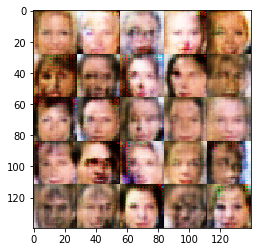

Epoch 1/2; Discriminator Loss: 1.1565; Generator Loss: 0.6873
Epoch 1/2; Discriminator Loss: 2.1110; Generator Loss: 2.1473
Epoch 1/2; Discriminator Loss: 0.9753; Generator Loss: 1.3009
Epoch 1/2; Discriminator Loss: 1.1664; Generator Loss: 0.7294
Epoch 1/2; Discriminator Loss: 0.9567; Generator Loss: 1.2612
Epoch 1/2; Discriminator Loss: 1.5698; Generator Loss: 1.2956
Epoch 1/2; Discriminator Loss: 1.0657; Generator Loss: 0.7923
Epoch 1/2; Discriminator Loss: 1.3705; Generator Loss: 1.2802
Epoch 1/2; Discriminator Loss: 1.0577; Generator Loss: 0.7851
Epoch 1/2; Discriminator Loss: 1.5897; Generator Loss: 1.6919


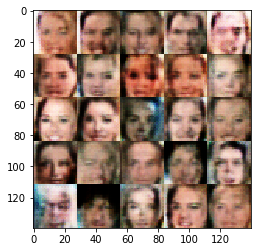

Epoch 1/2; Discriminator Loss: 1.5813; Generator Loss: 0.3984
Epoch 1/2; Discriminator Loss: 1.0795; Generator Loss: 1.2961
Epoch 1/2; Discriminator Loss: 1.0701; Generator Loss: 1.6452
Epoch 1/2; Discriminator Loss: 1.2217; Generator Loss: 0.8039
Epoch 1/2; Discriminator Loss: 1.4059; Generator Loss: 0.6516
Epoch 1/2; Discriminator Loss: 1.1703; Generator Loss: 0.9204
Epoch 1/2; Discriminator Loss: 1.2536; Generator Loss: 1.2155
Epoch 1/2; Discriminator Loss: 1.2110; Generator Loss: 0.7360
Epoch 1/2; Discriminator Loss: 1.5052; Generator Loss: 0.5543
Epoch 1/2; Discriminator Loss: 0.8150; Generator Loss: 1.2251


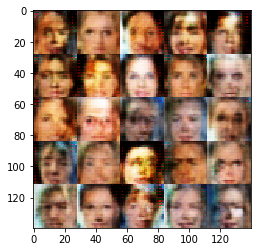

Epoch 1/2; Discriminator Loss: 1.3448; Generator Loss: 0.5474
Epoch 1/2; Discriminator Loss: 1.0546; Generator Loss: 1.1923
Epoch 1/2; Discriminator Loss: 1.3089; Generator Loss: 0.5886
Epoch 1/2; Discriminator Loss: 1.5492; Generator Loss: 0.4230
Epoch 1/2; Discriminator Loss: 1.1855; Generator Loss: 0.9231
Epoch 1/2; Discriminator Loss: 2.3618; Generator Loss: 2.6599
Epoch 1/2; Discriminator Loss: 1.2022; Generator Loss: 1.4036
Epoch 1/2; Discriminator Loss: 1.8532; Generator Loss: 0.2890
Epoch 1/2; Discriminator Loss: 1.6010; Generator Loss: 0.4087
Epoch 1/2; Discriminator Loss: 1.2090; Generator Loss: 0.7752


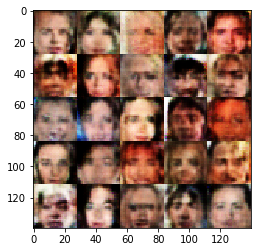

Epoch 1/2; Discriminator Loss: 1.2753; Generator Loss: 1.2423
Epoch 1/2; Discriminator Loss: 1.2011; Generator Loss: 0.7737
Epoch 1/2; Discriminator Loss: 1.0486; Generator Loss: 1.0937
Epoch 1/2; Discriminator Loss: 1.7688; Generator Loss: 2.5185
Epoch 1/2; Discriminator Loss: 1.3830; Generator Loss: 0.5131
Epoch 1/2; Discriminator Loss: 1.4244; Generator Loss: 1.6653
Epoch 1/2; Discriminator Loss: 1.4268; Generator Loss: 0.7167
Epoch 1/2; Discriminator Loss: 1.3799; Generator Loss: 0.8345
Epoch 1/2; Discriminator Loss: 1.2503; Generator Loss: 0.8500
Epoch 1/2; Discriminator Loss: 1.0349; Generator Loss: 1.0825


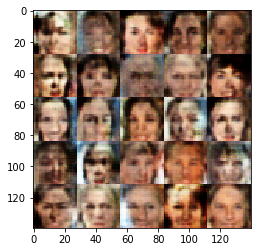

Epoch 1/2; Discriminator Loss: 1.3100; Generator Loss: 0.8404
Epoch 1/2; Discriminator Loss: 1.0421; Generator Loss: 1.7795
Epoch 1/2; Discriminator Loss: 1.4513; Generator Loss: 0.5260
Epoch 1/2; Discriminator Loss: 1.3918; Generator Loss: 1.3968
Epoch 1/2; Discriminator Loss: 1.2202; Generator Loss: 1.5349
Epoch 1/2; Discriminator Loss: 1.0217; Generator Loss: 1.1337
Epoch 1/2; Discriminator Loss: 1.4066; Generator Loss: 0.5155
Epoch 1/2; Discriminator Loss: 1.4206; Generator Loss: 0.6877
Epoch 1/2; Discriminator Loss: 1.3310; Generator Loss: 0.5556
Epoch 1/2; Discriminator Loss: 1.1492; Generator Loss: 0.8797


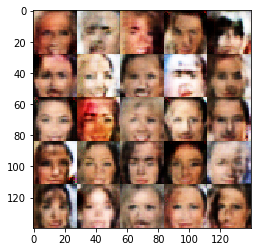

Epoch 1/2; Discriminator Loss: 1.2757; Generator Loss: 0.9567
Epoch 1/2; Discriminator Loss: 1.3257; Generator Loss: 0.6045
Epoch 1/2; Discriminator Loss: 1.5444; Generator Loss: 0.7962
Epoch 1/2; Discriminator Loss: 1.1336; Generator Loss: 0.7840
Epoch 1/2; Discriminator Loss: 1.1180; Generator Loss: 1.8315
Epoch 1/2; Discriminator Loss: 1.3581; Generator Loss: 0.5390
Epoch 1/2; Discriminator Loss: 1.4092; Generator Loss: 0.8984
Epoch 1/2; Discriminator Loss: 1.1677; Generator Loss: 1.2164
Epoch 1/2; Discriminator Loss: 2.0057; Generator Loss: 1.6373
Epoch 1/2; Discriminator Loss: 1.2914; Generator Loss: 0.6288


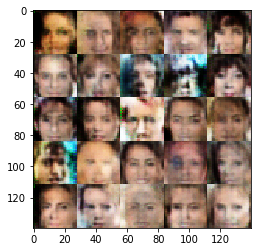

Epoch 1/2; Discriminator Loss: 1.2985; Generator Loss: 0.6111
Epoch 1/2; Discriminator Loss: 0.6278; Generator Loss: 2.0133
Epoch 1/2; Discriminator Loss: 0.4585; Generator Loss: 3.0102
Epoch 1/2; Discriminator Loss: 2.1499; Generator Loss: 3.2185
Epoch 1/2; Discriminator Loss: 1.3522; Generator Loss: 0.7148
Epoch 1/2; Discriminator Loss: 0.6933; Generator Loss: 1.5689
Epoch 1/2; Discriminator Loss: 2.1394; Generator Loss: 0.3139
Epoch 1/2; Discriminator Loss: 1.5175; Generator Loss: 0.4287
Epoch 1/2; Discriminator Loss: 1.0830; Generator Loss: 1.1674
Epoch 1/2; Discriminator Loss: 1.0986; Generator Loss: 0.8408


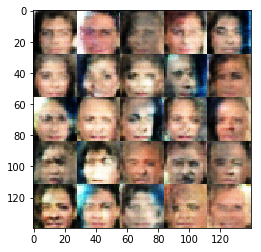

Epoch 1/2; Discriminator Loss: 1.8743; Generator Loss: 2.4007
Epoch 1/2; Discriminator Loss: 0.7936; Generator Loss: 1.6466
Epoch 1/2; Discriminator Loss: 1.0481; Generator Loss: 1.6103
Epoch 1/2; Discriminator Loss: 0.6408; Generator Loss: 1.4802
Epoch 1/2; Discriminator Loss: 1.2570; Generator Loss: 0.7291
Epoch 1/2; Discriminator Loss: 0.8363; Generator Loss: 1.0837
Epoch 1/2; Discriminator Loss: 0.9197; Generator Loss: 2.0363
Epoch 1/2; Discriminator Loss: 1.1861; Generator Loss: 1.0915
Epoch 1/2; Discriminator Loss: 1.3602; Generator Loss: 1.5391
Epoch 1/2; Discriminator Loss: 1.0592; Generator Loss: 0.7838


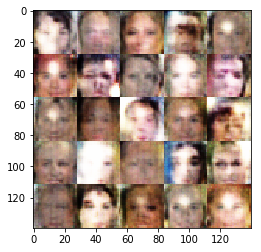

Epoch 1/2; Discriminator Loss: 1.2914; Generator Loss: 0.7628
Epoch 1/2; Discriminator Loss: 1.9394; Generator Loss: 0.3199
Epoch 1/2; Discriminator Loss: 1.5685; Generator Loss: 1.4049
Epoch 1/2; Discriminator Loss: 1.1531; Generator Loss: 0.8161
Epoch 1/2; Discriminator Loss: 1.3809; Generator Loss: 0.9771
Epoch 1/2; Discriminator Loss: 1.2968; Generator Loss: 1.2932
Epoch 1/2; Discriminator Loss: 1.6208; Generator Loss: 0.5053
Epoch 1/2; Discriminator Loss: 1.3369; Generator Loss: 0.7084
Epoch 1/2; Discriminator Loss: 1.4504; Generator Loss: 0.6165
Epoch 1/2; Discriminator Loss: 1.2478; Generator Loss: 0.7349


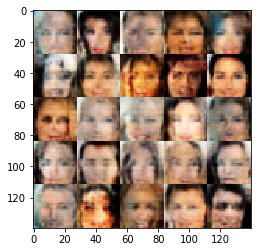

Epoch 1/2; Discriminator Loss: 1.2924; Generator Loss: 0.7360
Epoch 1/2; Discriminator Loss: 1.0489; Generator Loss: 1.2044
Epoch 1/2; Discriminator Loss: 1.6864; Generator Loss: 0.4388
Epoch 1/2; Discriminator Loss: 1.2698; Generator Loss: 0.8018
Epoch 1/2; Discriminator Loss: 1.6214; Generator Loss: 0.4585
Epoch 1/2; Discriminator Loss: 1.3029; Generator Loss: 1.0311
Epoch 1/2; Discriminator Loss: 1.0788; Generator Loss: 1.1004
Epoch 1/2; Discriminator Loss: 1.3291; Generator Loss: 0.9763
Epoch 1/2; Discriminator Loss: 1.2637; Generator Loss: 0.8181
Epoch 1/2; Discriminator Loss: 1.4538; Generator Loss: 0.5282


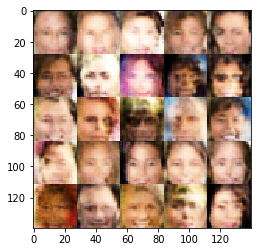

Epoch 1/2; Discriminator Loss: 1.3826; Generator Loss: 0.9363
Epoch 1/2; Discriminator Loss: 1.3374; Generator Loss: 0.6386
Epoch 1/2; Discriminator Loss: 1.3722; Generator Loss: 0.7620
Epoch 1/2; Discriminator Loss: 1.3923; Generator Loss: 0.6008
Epoch 1/2; Discriminator Loss: 1.3978; Generator Loss: 0.8270
Epoch 1/2; Discriminator Loss: 1.6220; Generator Loss: 0.6340
Epoch 1/2; Discriminator Loss: 1.3015; Generator Loss: 0.6444
Epoch 1/2; Discriminator Loss: 1.4970; Generator Loss: 0.5614
Epoch 1/2; Discriminator Loss: 1.6592; Generator Loss: 1.1892
Epoch 1/2; Discriminator Loss: 1.1945; Generator Loss: 0.8899


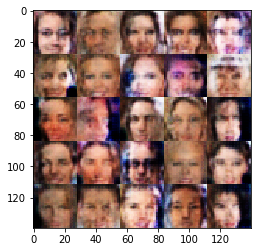

Epoch 1/2; Discriminator Loss: 1.2616; Generator Loss: 0.7319
Epoch 1/2; Discriminator Loss: 1.2109; Generator Loss: 0.9680
Epoch 1/2; Discriminator Loss: 1.5821; Generator Loss: 0.3929
Epoch 1/2; Discriminator Loss: 1.5368; Generator Loss: 0.7029
Epoch 1/2; Discriminator Loss: 1.2810; Generator Loss: 0.7620
Epoch 1/2; Discriminator Loss: 1.5550; Generator Loss: 0.4409
Epoch 1/2; Discriminator Loss: 1.4645; Generator Loss: 1.1733
Epoch 1/2; Discriminator Loss: 1.3420; Generator Loss: 0.8020
Epoch 1/2; Discriminator Loss: 1.1972; Generator Loss: 0.9708
Epoch 1/2; Discriminator Loss: 1.2419; Generator Loss: 0.8804


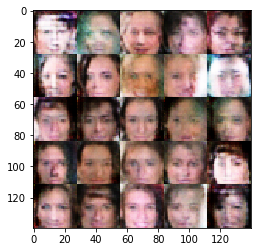

Epoch 1/2; Discriminator Loss: 1.5822; Generator Loss: 0.5022
Epoch 1/2; Discriminator Loss: 1.4153; Generator Loss: 0.8267
Epoch 1/2; Discriminator Loss: 1.3954; Generator Loss: 0.8801
Epoch 1/2; Discriminator Loss: 1.6405; Generator Loss: 0.5078
Epoch 1/2; Discriminator Loss: 1.2137; Generator Loss: 0.8230
Epoch 1/2; Discriminator Loss: 1.2148; Generator Loss: 0.9581
Epoch 1/2; Discriminator Loss: 1.3297; Generator Loss: 0.6217
Epoch 1/2; Discriminator Loss: 1.3665; Generator Loss: 0.6935
Epoch 1/2; Discriminator Loss: 1.3618; Generator Loss: 0.9212
Epoch 1/2; Discriminator Loss: 1.4482; Generator Loss: 0.8544


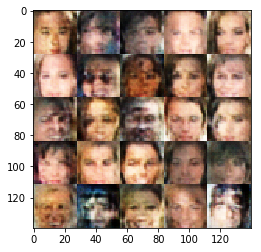

Epoch 1/2; Discriminator Loss: 1.3753; Generator Loss: 0.6992
Epoch 1/2; Discriminator Loss: 1.3588; Generator Loss: 1.0564
Epoch 1/2; Discriminator Loss: 1.5045; Generator Loss: 0.6229
Epoch 1/2; Discriminator Loss: 1.4431; Generator Loss: 0.6353
Epoch 1/2; Discriminator Loss: 1.2812; Generator Loss: 1.2195
Epoch 1/2; Discriminator Loss: 1.2896; Generator Loss: 0.6798
Epoch 1/2; Discriminator Loss: 1.6183; Generator Loss: 0.5966
Epoch 1/2; Discriminator Loss: 1.3457; Generator Loss: 0.7185
Epoch 1/2; Discriminator Loss: 1.2623; Generator Loss: 0.9310
Epoch 1/2; Discriminator Loss: 1.2559; Generator Loss: 0.8397


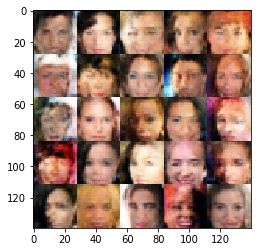

Epoch 1/2; Discriminator Loss: 1.3628; Generator Loss: 0.9177
Epoch 1/2; Discriminator Loss: 1.3771; Generator Loss: 0.9651
Epoch 2/2; Discriminator Loss: 1.2974; Generator Loss: 0.7515
Epoch 2/2; Discriminator Loss: 1.5513; Generator Loss: 0.4712
Epoch 2/2; Discriminator Loss: 1.4196; Generator Loss: 0.7217
Epoch 2/2; Discriminator Loss: 1.3932; Generator Loss: 0.8648
Epoch 2/2; Discriminator Loss: 1.3255; Generator Loss: 0.6761
Epoch 2/2; Discriminator Loss: 1.3309; Generator Loss: 0.8614
Epoch 2/2; Discriminator Loss: 1.2435; Generator Loss: 0.8537
Epoch 2/2; Discriminator Loss: 1.3703; Generator Loss: 0.7959


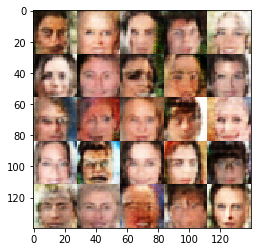

Epoch 2/2; Discriminator Loss: 1.4441; Generator Loss: 0.7106
Epoch 2/2; Discriminator Loss: 1.3342; Generator Loss: 0.6932
Epoch 2/2; Discriminator Loss: 1.4309; Generator Loss: 0.7648
Epoch 2/2; Discriminator Loss: 1.2846; Generator Loss: 0.8996
Epoch 2/2; Discriminator Loss: 1.5215; Generator Loss: 0.5901
Epoch 2/2; Discriminator Loss: 1.3517; Generator Loss: 0.7799
Epoch 2/2; Discriminator Loss: 1.3266; Generator Loss: 0.8984
Epoch 2/2; Discriminator Loss: 1.3973; Generator Loss: 0.7234
Epoch 2/2; Discriminator Loss: 1.2659; Generator Loss: 0.9101
Epoch 2/2; Discriminator Loss: 1.3891; Generator Loss: 0.7241


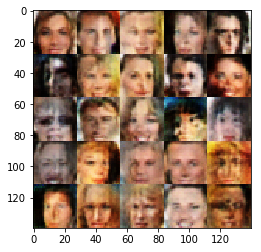

Epoch 2/2; Discriminator Loss: 1.3502; Generator Loss: 0.7659
Epoch 2/2; Discriminator Loss: 1.3002; Generator Loss: 0.7728
Epoch 2/2; Discriminator Loss: 1.3699; Generator Loss: 0.6753
Epoch 2/2; Discriminator Loss: 1.3241; Generator Loss: 0.7940
Epoch 2/2; Discriminator Loss: 1.3528; Generator Loss: 0.7419
Epoch 2/2; Discriminator Loss: 1.3700; Generator Loss: 0.6192
Epoch 2/2; Discriminator Loss: 1.4292; Generator Loss: 0.6855
Epoch 2/2; Discriminator Loss: 1.4243; Generator Loss: 0.6141
Epoch 2/2; Discriminator Loss: 1.3489; Generator Loss: 0.9251
Epoch 2/2; Discriminator Loss: 1.4031; Generator Loss: 0.6427


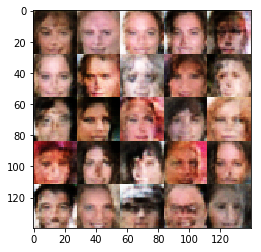

Epoch 2/2; Discriminator Loss: 1.3120; Generator Loss: 0.7299
Epoch 2/2; Discriminator Loss: 1.4405; Generator Loss: 0.7730
Epoch 2/2; Discriminator Loss: 1.4371; Generator Loss: 0.7553
Epoch 2/2; Discriminator Loss: 1.3472; Generator Loss: 0.7135
Epoch 2/2; Discriminator Loss: 1.3218; Generator Loss: 0.7792
Epoch 2/2; Discriminator Loss: 1.2779; Generator Loss: 0.7878
Epoch 2/2; Discriminator Loss: 1.4146; Generator Loss: 0.7456
Epoch 2/2; Discriminator Loss: 1.5340; Generator Loss: 0.6189
Epoch 2/2; Discriminator Loss: 1.4114; Generator Loss: 0.6796
Epoch 2/2; Discriminator Loss: 1.3496; Generator Loss: 0.6909


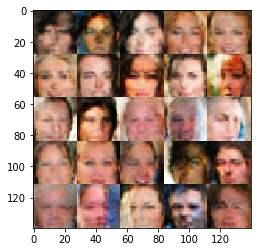

Epoch 2/2; Discriminator Loss: 1.3478; Generator Loss: 0.7145
Epoch 2/2; Discriminator Loss: 1.3701; Generator Loss: 0.7223
Epoch 2/2; Discriminator Loss: 1.2020; Generator Loss: 0.8042
Epoch 2/2; Discriminator Loss: 1.2411; Generator Loss: 0.8443
Epoch 2/2; Discriminator Loss: 1.3365; Generator Loss: 0.7049
Epoch 2/2; Discriminator Loss: 1.2639; Generator Loss: 0.9580
Epoch 2/2; Discriminator Loss: 1.3605; Generator Loss: 0.7135
Epoch 2/2; Discriminator Loss: 1.3548; Generator Loss: 0.8025
Epoch 2/2; Discriminator Loss: 1.2458; Generator Loss: 0.8409
Epoch 2/2; Discriminator Loss: 1.4665; Generator Loss: 0.6242


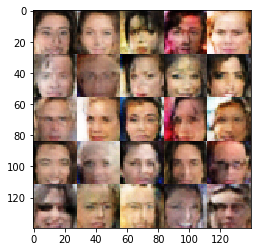

Epoch 2/2; Discriminator Loss: 1.3516; Generator Loss: 0.7016
Epoch 2/2; Discriminator Loss: 1.1893; Generator Loss: 1.0424
Epoch 2/2; Discriminator Loss: 1.7973; Generator Loss: 1.7394
Epoch 2/2; Discriminator Loss: 1.2240; Generator Loss: 0.8314
Epoch 2/2; Discriminator Loss: 1.1365; Generator Loss: 0.9802
Epoch 2/2; Discriminator Loss: 1.2901; Generator Loss: 0.9013
Epoch 2/2; Discriminator Loss: 1.4372; Generator Loss: 0.9747
Epoch 2/2; Discriminator Loss: 1.3819; Generator Loss: 0.6876
Epoch 2/2; Discriminator Loss: 1.4274; Generator Loss: 0.6658
Epoch 2/2; Discriminator Loss: 1.3601; Generator Loss: 0.7826


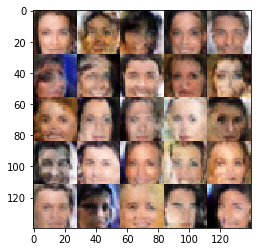

Epoch 2/2; Discriminator Loss: 1.4039; Generator Loss: 0.6605
Epoch 2/2; Discriminator Loss: 1.3814; Generator Loss: 0.8321
Epoch 2/2; Discriminator Loss: 1.2583; Generator Loss: 1.0616
Epoch 2/2; Discriminator Loss: 1.3656; Generator Loss: 0.7518
Epoch 2/2; Discriminator Loss: 1.3096; Generator Loss: 0.8894
Epoch 2/2; Discriminator Loss: 1.2943; Generator Loss: 0.9344
Epoch 2/2; Discriminator Loss: 1.3543; Generator Loss: 0.7008
Epoch 2/2; Discriminator Loss: 1.3858; Generator Loss: 0.6233
Epoch 2/2; Discriminator Loss: 1.4363; Generator Loss: 0.6047
Epoch 2/2; Discriminator Loss: 1.2579; Generator Loss: 0.8793


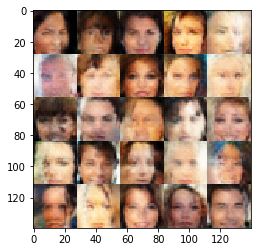

Epoch 2/2; Discriminator Loss: 1.3496; Generator Loss: 0.6593
Epoch 2/2; Discriminator Loss: 1.3233; Generator Loss: 0.8255
Epoch 2/2; Discriminator Loss: 1.3545; Generator Loss: 0.6821
Epoch 2/2; Discriminator Loss: 1.3146; Generator Loss: 0.9111
Epoch 2/2; Discriminator Loss: 1.3972; Generator Loss: 0.7982
Epoch 2/2; Discriminator Loss: 1.3698; Generator Loss: 0.6924
Epoch 2/2; Discriminator Loss: 1.2290; Generator Loss: 1.0135
Epoch 2/2; Discriminator Loss: 1.3547; Generator Loss: 0.9629
Epoch 2/2; Discriminator Loss: 1.4344; Generator Loss: 0.7210
Epoch 2/2; Discriminator Loss: 1.4371; Generator Loss: 0.7179


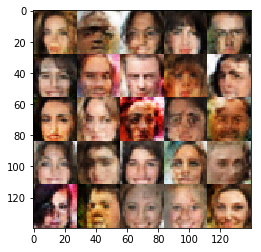

Epoch 2/2; Discriminator Loss: 1.4174; Generator Loss: 0.7015
Epoch 2/2; Discriminator Loss: 1.3116; Generator Loss: 0.7141
Epoch 2/2; Discriminator Loss: 1.2412; Generator Loss: 0.9509
Epoch 2/2; Discriminator Loss: 1.3777; Generator Loss: 0.7725
Epoch 2/2; Discriminator Loss: 1.3435; Generator Loss: 0.7333
Epoch 2/2; Discriminator Loss: 1.3859; Generator Loss: 0.6852
Epoch 2/2; Discriminator Loss: 1.3487; Generator Loss: 0.8706
Epoch 2/2; Discriminator Loss: 1.3230; Generator Loss: 0.7126
Epoch 2/2; Discriminator Loss: 1.3614; Generator Loss: 0.6266
Epoch 2/2; Discriminator Loss: 1.5324; Generator Loss: 0.6305


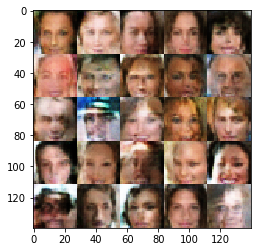

Epoch 2/2; Discriminator Loss: 1.1973; Generator Loss: 0.9574
Epoch 2/2; Discriminator Loss: 1.2886; Generator Loss: 1.1776
Epoch 2/2; Discriminator Loss: 1.2397; Generator Loss: 0.7827
Epoch 2/2; Discriminator Loss: 1.3479; Generator Loss: 0.7150
Epoch 2/2; Discriminator Loss: 1.3356; Generator Loss: 0.7429
Epoch 2/2; Discriminator Loss: 1.3982; Generator Loss: 0.8196
Epoch 2/2; Discriminator Loss: 1.4275; Generator Loss: 0.6952
Epoch 2/2; Discriminator Loss: 1.2980; Generator Loss: 0.7986
Epoch 2/2; Discriminator Loss: 1.5536; Generator Loss: 0.6906
Epoch 2/2; Discriminator Loss: 1.3788; Generator Loss: 0.9207


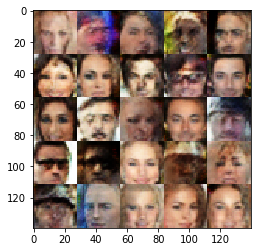

Epoch 2/2; Discriminator Loss: 1.3094; Generator Loss: 0.7087
Epoch 2/2; Discriminator Loss: 1.2981; Generator Loss: 0.7515
Epoch 2/2; Discriminator Loss: 1.4901; Generator Loss: 0.5583
Epoch 2/2; Discriminator Loss: 1.3854; Generator Loss: 0.7380
Epoch 2/2; Discriminator Loss: 1.2487; Generator Loss: 0.7174
Epoch 2/2; Discriminator Loss: 1.4678; Generator Loss: 0.6898
Epoch 2/2; Discriminator Loss: 1.3414; Generator Loss: 0.6294
Epoch 2/2; Discriminator Loss: 1.3836; Generator Loss: 0.7884
Epoch 2/2; Discriminator Loss: 1.3463; Generator Loss: 0.7655
Epoch 2/2; Discriminator Loss: 1.3246; Generator Loss: 0.6224


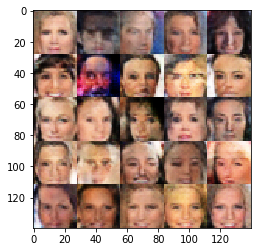

Epoch 2/2; Discriminator Loss: 1.3933; Generator Loss: 0.7584
Epoch 2/2; Discriminator Loss: 1.4050; Generator Loss: 0.7430
Epoch 2/2; Discriminator Loss: 1.3786; Generator Loss: 0.9068
Epoch 2/2; Discriminator Loss: 1.3587; Generator Loss: 0.8793
Epoch 2/2; Discriminator Loss: 1.4313; Generator Loss: 0.5793
Epoch 2/2; Discriminator Loss: 1.3092; Generator Loss: 0.7806
Epoch 2/2; Discriminator Loss: 1.5002; Generator Loss: 0.5664
Epoch 2/2; Discriminator Loss: 1.3535; Generator Loss: 0.6773
Epoch 2/2; Discriminator Loss: 1.2699; Generator Loss: 0.7670
Epoch 2/2; Discriminator Loss: 1.3559; Generator Loss: 0.6509


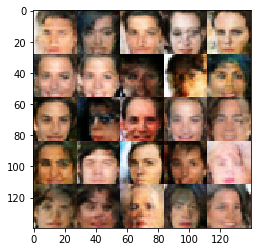

Epoch 2/2; Discriminator Loss: 1.4055; Generator Loss: 0.6873
Epoch 2/2; Discriminator Loss: 1.1602; Generator Loss: 0.8530
Epoch 2/2; Discriminator Loss: 1.3536; Generator Loss: 0.8412
Epoch 2/2; Discriminator Loss: 1.3521; Generator Loss: 0.7730
Epoch 2/2; Discriminator Loss: 1.2770; Generator Loss: 0.9465
Epoch 2/2; Discriminator Loss: 1.3884; Generator Loss: 0.9100
Epoch 2/2; Discriminator Loss: 1.3499; Generator Loss: 0.6751
Epoch 2/2; Discriminator Loss: 0.8969; Generator Loss: 1.2076
Epoch 2/2; Discriminator Loss: 1.3741; Generator Loss: 0.8600
Epoch 2/2; Discriminator Loss: 1.2373; Generator Loss: 0.9745


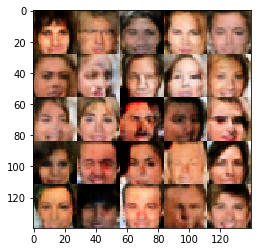

Epoch 2/2; Discriminator Loss: 1.2477; Generator Loss: 1.0528
Epoch 2/2; Discriminator Loss: 1.3295; Generator Loss: 0.7399
Epoch 2/2; Discriminator Loss: 1.3811; Generator Loss: 0.7152
Epoch 2/2; Discriminator Loss: 1.4492; Generator Loss: 0.7168
Epoch 2/2; Discriminator Loss: 1.4331; Generator Loss: 0.6396
Epoch 2/2; Discriminator Loss: 1.3265; Generator Loss: 0.7229
Epoch 2/2; Discriminator Loss: 1.4021; Generator Loss: 1.0277
Epoch 2/2; Discriminator Loss: 1.2841; Generator Loss: 0.8901
Epoch 2/2; Discriminator Loss: 1.2754; Generator Loss: 0.8120
Epoch 2/2; Discriminator Loss: 1.3600; Generator Loss: 0.8267


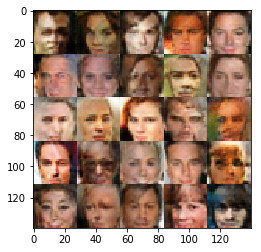

Epoch 2/2; Discriminator Loss: 1.3219; Generator Loss: 0.7330
Epoch 2/2; Discriminator Loss: 1.3450; Generator Loss: 0.5894
Epoch 2/2; Discriminator Loss: 1.4973; Generator Loss: 0.6466
Epoch 2/2; Discriminator Loss: 1.4165; Generator Loss: 0.5420
Epoch 2/2; Discriminator Loss: 1.3114; Generator Loss: 0.8620
Epoch 2/2; Discriminator Loss: 1.3740; Generator Loss: 0.5511
Epoch 2/2; Discriminator Loss: 1.2774; Generator Loss: 0.8322
Epoch 2/2; Discriminator Loss: 1.3517; Generator Loss: 0.8402
Epoch 2/2; Discriminator Loss: 1.4595; Generator Loss: 0.7057
Epoch 2/2; Discriminator Loss: 1.4167; Generator Loss: 0.7566


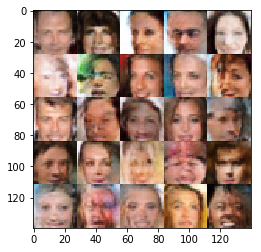

Epoch 2/2; Discriminator Loss: 1.5163; Generator Loss: 0.5386
Epoch 2/2; Discriminator Loss: 1.4820; Generator Loss: 0.5244
Epoch 2/2; Discriminator Loss: 1.4140; Generator Loss: 0.6454
Epoch 2/2; Discriminator Loss: 1.3547; Generator Loss: 0.8180
Epoch 2/2; Discriminator Loss: 1.3285; Generator Loss: 0.8345
Epoch 2/2; Discriminator Loss: 1.3773; Generator Loss: 0.7076
Epoch 2/2; Discriminator Loss: 1.4059; Generator Loss: 0.6172
Epoch 2/2; Discriminator Loss: 1.4849; Generator Loss: 0.4493
Epoch 2/2; Discriminator Loss: 1.3100; Generator Loss: 0.7083
Epoch 2/2; Discriminator Loss: 1.3484; Generator Loss: 0.6685


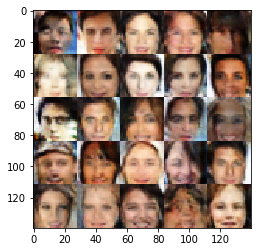

Epoch 2/2; Discriminator Loss: 1.4534; Generator Loss: 0.5535
Epoch 2/2; Discriminator Loss: 1.5668; Generator Loss: 0.4386
Epoch 2/2; Discriminator Loss: 1.2942; Generator Loss: 0.8865
Epoch 2/2; Discriminator Loss: 1.3052; Generator Loss: 0.8398
Epoch 2/2; Discriminator Loss: 1.2901; Generator Loss: 0.7008
Epoch 2/2; Discriminator Loss: 1.4737; Generator Loss: 0.6748
Epoch 2/2; Discriminator Loss: 1.4214; Generator Loss: 0.6070
Epoch 2/2; Discriminator Loss: 1.3490; Generator Loss: 0.7510
Epoch 2/2; Discriminator Loss: 1.4983; Generator Loss: 0.8264
Epoch 2/2; Discriminator Loss: 1.4145; Generator Loss: 0.7833


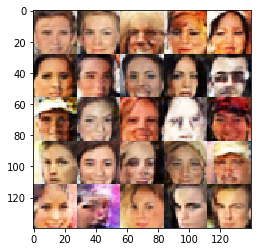

Epoch 2/2; Discriminator Loss: 1.5008; Generator Loss: 0.5688
Epoch 2/2; Discriminator Loss: 1.3920; Generator Loss: 0.6443
Epoch 2/2; Discriminator Loss: 1.3825; Generator Loss: 0.7310
Epoch 2/2; Discriminator Loss: 1.3349; Generator Loss: 0.7728
Epoch 2/2; Discriminator Loss: 1.2632; Generator Loss: 0.8744
Epoch 2/2; Discriminator Loss: 1.3450; Generator Loss: 0.7796
Epoch 2/2; Discriminator Loss: 1.3115; Generator Loss: 0.9860
Epoch 2/2; Discriminator Loss: 1.3628; Generator Loss: 0.7098
Epoch 2/2; Discriminator Loss: 1.3199; Generator Loss: 0.8077
Epoch 2/2; Discriminator Loss: 1.3635; Generator Loss: 0.8922


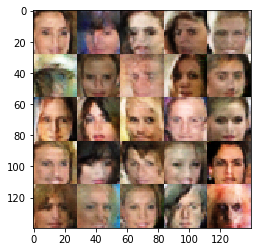

Epoch 2/2; Discriminator Loss: 1.3690; Generator Loss: 0.7339
Epoch 2/2; Discriminator Loss: 1.3244; Generator Loss: 0.6850
Epoch 2/2; Discriminator Loss: 1.4123; Generator Loss: 0.6627
Epoch 2/2; Discriminator Loss: 1.4251; Generator Loss: 0.6777
Epoch 2/2; Discriminator Loss: 1.3558; Generator Loss: 0.6860
Epoch 2/2; Discriminator Loss: 1.3049; Generator Loss: 0.6434
Epoch 2/2; Discriminator Loss: 1.4129; Generator Loss: 0.5729
Epoch 2/2; Discriminator Loss: 1.5681; Generator Loss: 0.6016
Epoch 2/2; Discriminator Loss: 1.2770; Generator Loss: 0.9249
Epoch 2/2; Discriminator Loss: 1.4329; Generator Loss: 0.5151


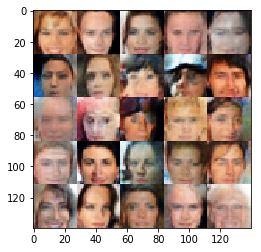

Epoch 2/2; Discriminator Loss: 1.3432; Generator Loss: 0.8815
Epoch 2/2; Discriminator Loss: 1.2698; Generator Loss: 0.7602
Epoch 2/2; Discriminator Loss: 1.2640; Generator Loss: 0.7989
Epoch 2/2; Discriminator Loss: 1.3372; Generator Loss: 0.7244
Epoch 2/2; Discriminator Loss: 1.4626; Generator Loss: 0.4949
Epoch 2/2; Discriminator Loss: 1.3588; Generator Loss: 0.7918
Epoch 2/2; Discriminator Loss: 1.4122; Generator Loss: 0.6108
Epoch 2/2; Discriminator Loss: 1.4626; Generator Loss: 0.6219
Epoch 2/2; Discriminator Loss: 1.4012; Generator Loss: 0.7420
Epoch 2/2; Discriminator Loss: 1.2617; Generator Loss: 0.8069


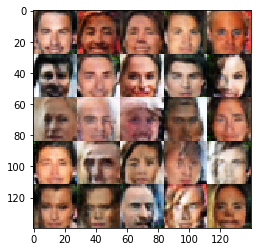

Epoch 2/2; Discriminator Loss: 1.3482; Generator Loss: 0.7968
Epoch 2/2; Discriminator Loss: 1.4900; Generator Loss: 0.6628
Epoch 2/2; Discriminator Loss: 1.3565; Generator Loss: 0.8054
Epoch 2/2; Discriminator Loss: 1.3897; Generator Loss: 0.6494
Epoch 2/2; Discriminator Loss: 1.3458; Generator Loss: 0.8100


In [14]:
batch_size  = 100
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.